In [1]:
import sys
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader
from typing import Union, Tuple

import pickle as pk

from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

# Network
**Define the CNN**
We implemented the CNN from the assignment with minor adjustments that we took from the ResNet paper:
1. We increase number of output channels in the last layer of every i-iteration instead of the first layer.

In [3]:
class ResNetLike(nn.Module):
  def __init__(self, depth_n):
    # Initialize as subclass of nn.Module inheriting all its functions
    super(ResNetLike, self).__init__()
    # Define intial layer
    self.start = nn.Sequential(OrderedDict([('conv0', nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)),
                ('relu0', nn.LeakyReLU()),
                ('bn0', nn.BatchNorm2d(16))]))
    self.i_list = [0, 1, 2]
    self.depth_n = depth_n
    self.block1_list = nn.ModuleList([])
    self.block2_list = nn.ModuleList([])
    self.identity_scale_list = nn.ModuleList([])
    # Store output of each of the i iterations
    self.add_channels_list = nn.ModuleList([])
    for i in self.i_list:
      # Define first block for iteration i (repeated 2n times)
      # Only range(2n-1) and not range(2n), because after 2n-1 iterations we add a layer that increases output channel numbers, 
      # which overall results in 2n iterations
        for n in range(2 * self.depth_n - 1):
            i_channels = 16 * (2 ** i)
            b1 = [nn.Conv2d(in_channels=i_channels, out_channels=i_channels, kernel_size=3, stride=1, padding=1),
                  nn.LeakyReLU(),
                  nn.BatchNorm2d(i_channels),
                  nn.Conv2d(in_channels=i_channels, out_channels=i_channels, kernel_size=3, stride=1, padding=1),
                  nn.LeakyReLU(),
                  nn.BatchNorm2d(i_channels)]
            self.block1_list.append(nn.Sequential(*b1))

#         if i != self.i_list[-1]:
        # Define closing block for iteration i
        i_channels = 16 * (2 ** i)
        last_channels = 16 * (2 ** (i+1))
        b2 = [nn.Conv2d(in_channels=i_channels, out_channels=i_channels, kernel_size=3, stride=1, padding=1),
              nn.LeakyReLU(),
              nn.BatchNorm2d(i_channels),
              nn.Conv2d(in_channels=i_channels, out_channels=i_channels, kernel_size=3, stride=2, padding=1),
              nn.LeakyReLU(),
              nn.BatchNorm2d(i_channels)]
        self.block2_list.append(nn.Sequential(*b2))
        # Skip connection: This layer addresses the issue with skip connections where x and F(x) don't have the same shape.
        # Shape of identity x is halfed using 2d average pooling.
        self.identity_scale_list.append(nn.AvgPool2d(2, stride=2))
        # Increase number of output channels in last layer of current iteration
        b3 = [nn.Conv2d(in_channels=i_channels, out_channels=last_channels, kernel_size=1, stride=1, padding=0),
                  nn.LeakyReLU(),
                  nn.BatchNorm2d(last_channels)]
        self.add_channels_list.append(nn.Sequential(*b3))
#         else:
#             i_channels = 16 * (2 ** i)
#             b2 = [nn.Conv2d(in_channels=i_channels, out_channels=i_channels, kernel_size=3, stride=1, padding=1),
#                   nn.LeakyReLU(),
#                   nn.BatchNorm2d(i_channels),
#                   nn.Conv2d(in_channels=i_channels, out_channels=i_channels, kernel_size=3, stride=1, padding=1),
#                   nn.LeakyReLU(),
#                   nn.BatchNorm2d(last_channels)]
#             self.block2_list.append(nn.Sequential(*b2))
#     self.end = nn.Sequential(*[nn.Linear(16 * (2 ** 2) * 8 * 8, 10), nn.Softmax(dim=1)])

    # Here we require dimension with 16*2^3 channels isntead of 16*2^2 because we just increased the number of output channels with b3
    # Possible improvement: add if statement to only increase number of output channels after iterations 0 and 1, but not 2
    # or change implementation to increase number of output channels in first layer of every i-iteration, instead of the last layer
    self.end = nn.Linear(16 * (2 ** 3) * 4 * 4, 10)
                                           

  def forward(self, x):
    self.MSE_losses = []
    MSE_func = nn.MSELoss()
    y = self.start(x)
    block1_counter = 0
    for i in self.i_list:
        for n in range(2 * self.depth_n - 1):
            identity = y
            # Skip connection I: learn F(x)=H(x)-x
            y = self.block1_list[block1_counter](y)
            # Skip connection II: add F(x)+x
            y += identity
            block1_counter += 1
            # Quantify error of identity mapping
            self.MSE_losses.append((i,n,MSE_func(identity, y)))
#         if i != self.i_list[-1]:
        identity = y
        # Skip connection I: learn F(x)=H(x)-x
        y = self.block2_list[i](y)
        # Skip connection II: scale identity x to shape of F(x) and add
        y += self.identity_scale_list[i](identity)
        self.MSE_losses.append((i,self.depth_n,MSE_func(self.identity_scale_list[i](identity), y)))
        y = self.add_channels_list[i](y)
#         else:
#             identity = y
#             y = self.block2_list[i](y)
#             y += identity
    return self.end(y.reshape([y.shape[0],-1]))
    

# Dataset

**Load CIFAR10 data**

In [5]:
#DataPath = r"D:\PatternRecognition_Data"
DataPath = "."
train_data = datasets.CIFAR10(DataPath, train=True, download=True, transform=transforms.ToTensor())

Extracting ./cifar-10-python.tar.gz to .


In [6]:
train_loader = DataLoader(train_data, batch_size=len(train_data))
batch = next(iter(train_loader))
x, y = batch
mean, std = torch.mean(x), torch.std(x)

**Normalize data and create train/test sets comprising batches of size 64**

In [10]:
transform = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
])

batch_size = 64
trainset = datasets.CIFAR10(root=DataPath, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.CIFAR10(root=DataPath, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


**Show some images from the training set**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 32, 32]) torch.Size([64])


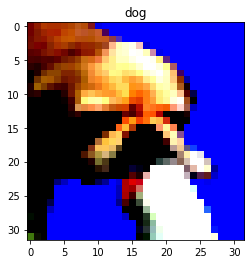

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


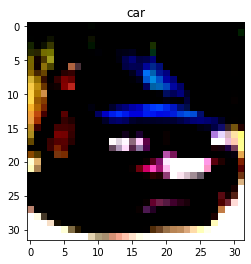

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


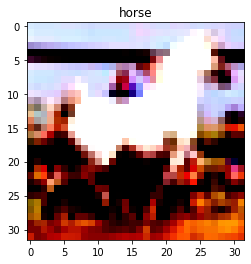

In [ ]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)
plt.imshow(x[0].permute(1, 2, 0))
plt.title(classes[y[0].item()])
plt.show()
plt.imshow(x[1].permute(1, 2, 0))
plt.title(classes[y[1].item()])
plt.show()
plt.imshow(x[2].permute(1, 2, 0))
plt.title(classes[y[2].item()])
plt.show()

# Train a CNN with depth 1

**For backprop training use cross entropy as loss function and Adam optimzation method**

In [11]:
# Test train batch size
next(iter(train_loader))[0].shape

torch.Size([64, 3, 32, 32])

In [12]:
# Initialize
resnet_model = ResNetLike(depth_n=1)
resnet_model.cuda()
resnet_optim = optim.Adam(resnet_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
probs = nn.Softmax(dim=1)

# Train
batch = next(iter(train_loader))
x, y = batch
x, y = x.cuda(), y.cuda()
output = resnet_model(x)
loss = criterion(output, y)
loss.backward()
resnet_optim.step()

**View classification probabilities and apply argmax classification layer**


In [13]:
# Softmax dim=1 : Values along the first axos will sum up to 1
softmax_output = probs(output)
print(softmax_output[0])
print(sum(softmax_output[0]))

tensor([0.2183, 0.0922, 0.1434, 0.0702, 0.0527, 0.0624, 0.0454, 0.0521, 0.1968,
        0.0665], device='cuda:0', grad_fn=<SelectBackward>)
tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)


In [14]:
torch.argmax(softmax_output, dim=1)

tensor([0, 5, 3, 2, 5, 3, 8, 3, 5, 4, 4, 1, 3, 6, 0, 3, 8, 2, 9, 9, 4, 5, 5, 5,
        5, 3, 9, 9, 3, 5, 5, 2, 4, 5, 4, 5, 4, 4, 2, 4, 4, 7, 0, 5, 5, 6, 2, 5,
        9, 2, 2, 6, 1, 2, 3, 9, 5, 5, 2, 5, 4, 3, 5, 1], device='cuda:0')

**Evaluate training accuracy**

In [15]:
print("One run accuracy:")
print(torch.sum(torch.argmax(softmax_output, dim=1) == y) / len(y))

One run accuracy:
tensor(0.0312, device='cuda:0')


# Define training and validation function

In [16]:
def train(
    model: nn.Module, 
    optimizer: optim.Optimizer, 
    data: Union[DataLoader, Tuple[DataLoader]], 
    max_epochs: int, 
    cuda=True):
  """
  Train a NN 'model' on 'data' in 'max_epochs' many epochs using 'optimizer' optimization method.
  """
  
  use_test = False
  if isinstance(data, DataLoader):
    train_loader = data
  elif isinstance(data, tuple):
    if len(data) == 2:
      train_loader, test_loader = data
      if not isinstance(train_loader, DataLoader):
        raise TypeError(f'Expected 1st entry of type DataLoader, but got {type(train_loader)}!')
      if not isinstance(test_loader, DataLoader):
        raise TypeError(f'Expected 2nd entry of type DataLoader, but got {type(test_loader)}!')
      use_test = True
    else:
      raise ValueError(f'Expected tuple of length 2, but got {len(data)}!')
  
  criterion = nn.CrossEntropyLoss()
  probs = nn.Softmax(dim=1)
  model.train()
  losses = []
  batch_total = len(train_loader)

  for epoch in range(max_epochs):
    samples_total = 0
    samples_correct = 0
    for batch_idx, batch in enumerate(train_loader):
      x, y = batch
      if cuda:
        x, y = x.cuda(), y.cuda()
      output = model(x)
      loss = criterion(output, y)
      loss.backward()
      optimizer.step()
        
      softmax_output = probs(output)
      
      yhat = torch.argmax(softmax_output, dim=1)

      samples_total += len(y)
      samples_correct += torch.sum(yhat == y)
      losses.append(loss.item())


      if batch_idx % 50 == 0:
        acc = float(samples_correct) / float(samples_total)

        if use_test:
          model.eval()

          test_x, test_y = next(iter(test_loader))
          if cuda:
            test_x, test_y = test_x.cuda(), test_y.cuda()
          test_output = model(test_x)
          test_loss = criterion(test_output, test_y)

          test_yhat = torch.argmax(test_output, dim=1)
          test_acc = float(torch.sum(test_yhat == test_y)) / float(len(test_y))
          
          model.train()

          sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} Loss: {loss.item():.6f} Acc: {acc:.2%} Test loss: {test_loss:.6f} Test acc: {test_acc:.2%}')
        else:
          sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} Loss: {loss.item():.6f} Acc: {acc:.2%}')

  return losses

In [17]:
def validate(model: nn.Module, data: DataLoader, cuda=True):
  """
  Evaluate performance of trained NN 'model' on 'data'.
  """
  criterion = nn.CrossEntropyLoss()
  probs = nn.Softmax(dim=1)
  losses = []
  correct_samples = 0
  total_samples = 0
  for x, y in data:
      if cuda:
        x, y = x.cuda(), y.cuda()
      output = model(x)
      loss = criterion(output, y)
      softmax_output = probs(output)
      yhat = torch.argmax(softmax_output, dim=1)
      losses.append(loss.item())
      correct_samples += torch.sum(yhat == y)
      total_samples += len(y)

  mean_losses = np.mean(losses)
  acc = float(correct_samples) / float(total_samples)
  print(f'Validation complete! Validation loss: {mean_losses:.6f}, Validation accuracy: {acc:.2%}')

  return mean_losses, acc

## Train a CNN of depth 3.

In [18]:
resnet_model = ResNetLike(depth_n=3)
summary(resnet_model, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         LeakyReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           2,320
         LeakyReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 16, 32, 32]           2,320
         LeakyReLU-8           [-1, 16, 32, 32]               0
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,320
        LeakyReLU-11           [-1, 16, 32, 32]               0
      BatchNorm2d-12           [-1, 16, 32, 32]              32
           Conv2d-13           [-1, 16, 32, 32]           2,320
        LeakyReLU-14           [-1, 16,

## Run the model training for different depths n
**We tested network depths from 1 to 5 and empirically found n=3 to yield the best accuracy**

In [19]:
n = 3 #1-5 tested, 3 was the best in test accuracy
resnet_model = ResNetLike(depth_n=n)
resnet_model = resnet_model.cuda()
resnet_optim = optim.Adam(resnet_model.parameters(), lr=1e-5)
resnet_losses = train(resnet_model, resnet_optim, (train_loader, test_loader), max_epochs=20)

Epoch: 19/20 Step: 750/782 Loss: 0.545656 Acc: 82.02% Test loss: 1.000926 Test acc: 75.00%

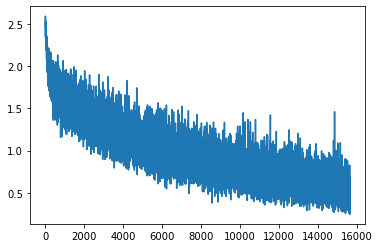

In [ ]:
plt.plot(resnet_losses)

### Result Training:
n=1: Loss: 0.111714 Acc: 96.81% Test loss: 2.012541 Test acc: 73.44% <br>
n=2: Loss: 0.349901 Acc: 86.95% Test loss: 1.573093 Test acc: 67.19% <br>
n=3: Loss: 0.323404 Acc: 87.81% Test loss: 0.604898 Test acc: 84.38% <br>
n=4: Loss: 0.435157 Acc: 83.01% Test loss: 0.828250 Test acc: 73.44% <br>
n=5: Loss: 0.495589 Acc: 80.37% Test loss: 0.883892 Test acc: 68.75% <br>

## Run the Testing:

In [ ]:
validate(resnet_model, test_loader)

Validation complete! Validation loss: 0.887750, Validation accuracy: 71.27%


(0.887749841258784, 0.7127)

### Result Testing:
n=1: Validation loss: 1.777780, Validation accuracy: 72.34% <br>
n=2: Validation loss: 0.953017, Validation accuracy: 72.99% <br>
n=3: Validation loss: 0.845809, Validation accuracy: 75.41% <br>
n=4: Validation loss: 0.854774, Validation accuracy: 73.53% <br>
n=5: Validation loss: 0.887750, Validation accuracy: 71.27% <br>

n=3 seems like the best option!

# Save Checkpoint

In [ ]:
checkpoint = {
    'model_state_dict': resnet_model.state_dict(),
    'optimizer_state_dict': resnet_optim.state_dict(),
    'depth_n': resnet_model.depth_n,
    'epoch': 10,
    'losses': resnet_losses
}

In [ ]:
filename = 'resnet_model_n3.pth'

In [ ]:

# checkpoint_path = os.path.join(root_path, 'My Drive', 'MLVideos', filename)

with open(filename, 'wb') as f:
  pk.dump(checkpoint, f)

# Load Checkpoint

In [ ]:
with open(filename, 'rb') as f:
  checkpoint_ = pk.load(f)

In [ ]:
resnet_model = ResNetLike(depth_n=checkpoint_['depth_n'])
resnet_model = resnet_model.cuda()
resnet_model.load_state_dict(checkpoint_['model_state_dict'])

<All keys matched successfully>

In [ ]:
validate(resnet_model, test_loader)

Validation complete! Validation loss: 0.840928, Validation accuracy: 75.69%


(0.8409276942538607, 0.7569)

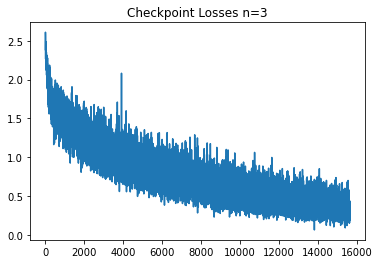

In [ ]:
plt.plot(checkpoint_['losses'])
plt.title("Checkpoint Losses n={}".format(checkpoint_['depth_n']))
plt.show()

# (a) Plot the filters of the first layer. What kind of features do they extract?


In [ ]:
next(resnet_model.parameters()).data[0]

tensor([[[-0.1575, -0.1100, -0.1774],
         [-0.1864,  0.0866, -0.1866],
         [-0.2408, -0.0061, -0.1600]],

        [[ 0.0588,  0.2078, -0.1063],
         [ 0.0838,  0.1051,  0.0878],
         [-0.1042,  0.1797, -0.2434]],

        [[ 0.2823,  0.2907, -0.0433],
         [ 0.3508,  0.2243,  0.1754],
         [ 0.0619, -0.0339, -0.1188]]], device='cuda:0')

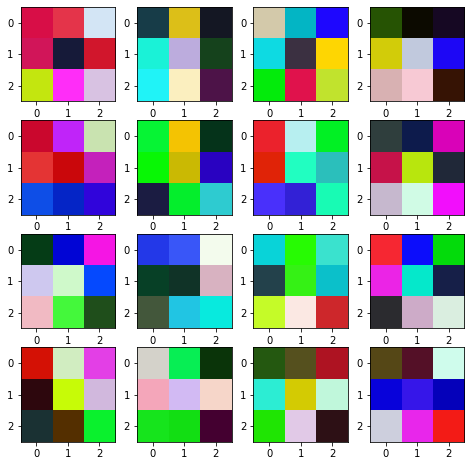

In [ ]:
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i, img in enumerate(next(resnet_model.parameters()).data):
    img = img.permute(1, 2, 0).cpu().numpy()
    fig.add_subplot(rows, columns, i+1)
    plt.imshow((img * 255).astype(np.uint8))
plt.show()

**Result**:

The first layer doesn't seem to extract any specific shapes but rather color patterns.

# (b) For every two convolutions with skip connection calculate the MSE of the input of those layer xin and the output xout: MSE(xin, xout). Does your network have layers that were learned to be the identity? (Optionally: Check if this happens during training)


In [ ]:
resnet_model.MSE_losses

[(0, 0, tensor(0.9380, device='cuda:0', grad_fn=<MseLossBackward>)),
 (0, 1, tensor(1.0739, device='cuda:0', grad_fn=<MseLossBackward>)),
 (0, 2, tensor(0.9321, device='cuda:0', grad_fn=<MseLossBackward>)),
 (0, 3, tensor(0.9710, device='cuda:0', grad_fn=<MseLossBackward>)),
 (0, 4, tensor(0.8867, device='cuda:0', grad_fn=<MseLossBackward>)),
 (0, 3, tensor(0.7907, device='cuda:0', grad_fn=<MseLossBackward>)),
 (1, 0, tensor(1.0499, device='cuda:0', grad_fn=<MseLossBackward>)),
 (1, 1, tensor(0.9085, device='cuda:0', grad_fn=<MseLossBackward>)),
 (1, 2, tensor(0.8428, device='cuda:0', grad_fn=<MseLossBackward>)),
 (1, 3, tensor(0.8340, device='cuda:0', grad_fn=<MseLossBackward>)),
 (1, 4, tensor(0.7912, device='cuda:0', grad_fn=<MseLossBackward>)),
 (1, 3, tensor(0.7344, device='cuda:0', grad_fn=<MseLossBackward>)),
 (2, 0, tensor(1.0355, device='cuda:0', grad_fn=<MseLossBackward>)),
 (2, 1, tensor(1.0071, device='cuda:0', grad_fn=<MseLossBackward>)),
 (2, 2, tensor(0.8953, device='cud

**Result:**


None of the MSE errors were 0, so none of the tensors before and after a skip connection layers were applied seem to be mapping to the identical values as before the layers.

# (c) Is deeper always better? Provide some evidence for your answer and explain why that is the case

### Taking our results from training/testing again:
Train: <br>
n=1: Loss: 0.111714 Acc: 96.81% Test loss: 2.012541 Test acc: 73.44% <br>
n=2: Loss: 0.349901 Acc: 86.95% Test loss: 1.573093 Test acc: 67.19% <br>
n=3: Loss: 0.323404 Acc: 87.81% Test loss: 0.604898 Test acc: 84.38% <br>
n=4: Loss: 0.435157 Acc: 83.01% Test loss: 0.828250 Test acc: 73.44% <br>
n=5: Loss: 0.495589 Acc: 80.37% Test loss: 0.883892 Test acc: 68.75% <br><br>
Test: <br>
n=1: Validation loss: 1.777780, Validation accuracy: 72.34% <br>
n=2: Validation loss: 0.953017, Validation accuracy: 72.99% <br>
n=3: Validation loss: 0.845809, Validation accuracy: 75.41% <br>
n=4: Validation loss: 0.854774, Validation accuracy: 73.53% <br>
n=5: Validation loss: 0.887750, Validation accuracy: 71.27% <br>

### Going deeper does not always mean getting a better prediction:
Low n fit the best to the training set, high n fitted worse to the training. <br>
But the testing accuracy looked more like a normal distribution around n=3 and got worse again for higher n